#### Loading the dataset

In [1]:
import pandas as pd

In [2]:
# Load the weekly aggregated sales data
weekly_data = pd.read_csv('../data/processed/weekly_aggregated_sales.csv')

# Display first few rows to understand the data
print(weekly_data.head())

       item_id store_id  wm_yr_wk  sales  sell_price  month  year
0  FOODS_1_001     CA_1     11101     10         2.0      1  2011
1  FOODS_1_001     CA_1     11101     10         2.0      2  2011
2  FOODS_1_001     CA_1     11102      6         2.0      2  2011
3  FOODS_1_001     CA_1     11103     10         2.0      2  2011
4  FOODS_1_001     CA_1     11104     13         2.0      2  2011


#### Splitting the data

In [6]:
# Function to split per item-store
def train_test_split_ts(df, test_size=0.2):
    df = df.sort_values('wm_yr_wk')
    split_idx = int(len(df) * (1 - test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    return train, test

 # Example for one item-store
item_store_df = weekly_data[(weekly_data['item_id'] == 'FOODS_1_001') & (weekly_data['store_id'] == 'CA_1')]
train_df, test_df = train_test_split_ts(item_store_df)

print(f"Train weeks: {train_df['wm_yr_wk'].min()} to {train_df['wm_yr_wk'].max()}")
print(f"Test weeks: {test_df['wm_yr_wk'].min()} to {test_df['wm_yr_wk'].max()}")

Train weeks: 11101 to 11513
Test weeks: 11514 to 11617


#### Feature Extraction/ Preprocessing 

In [ ]:
!pip install statsmodels


In [9]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity on training sales data
result = adfuller(train_df['sales'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Apply differencing if p-value > 0.05 (non-stationary)
if result[1] > 0.05:
    train_sales_diff = train_df['sales'].diff().dropna()
else:
    train_sales_diff = train_df['sales']


ADF Statistic: -4.097538619472479
p-value: 0.0009776375577506265


As p value of is less than 0.5 so differencing is not required. Also we get the value of d = 0 .

In [ ]:
pip install matplotlib

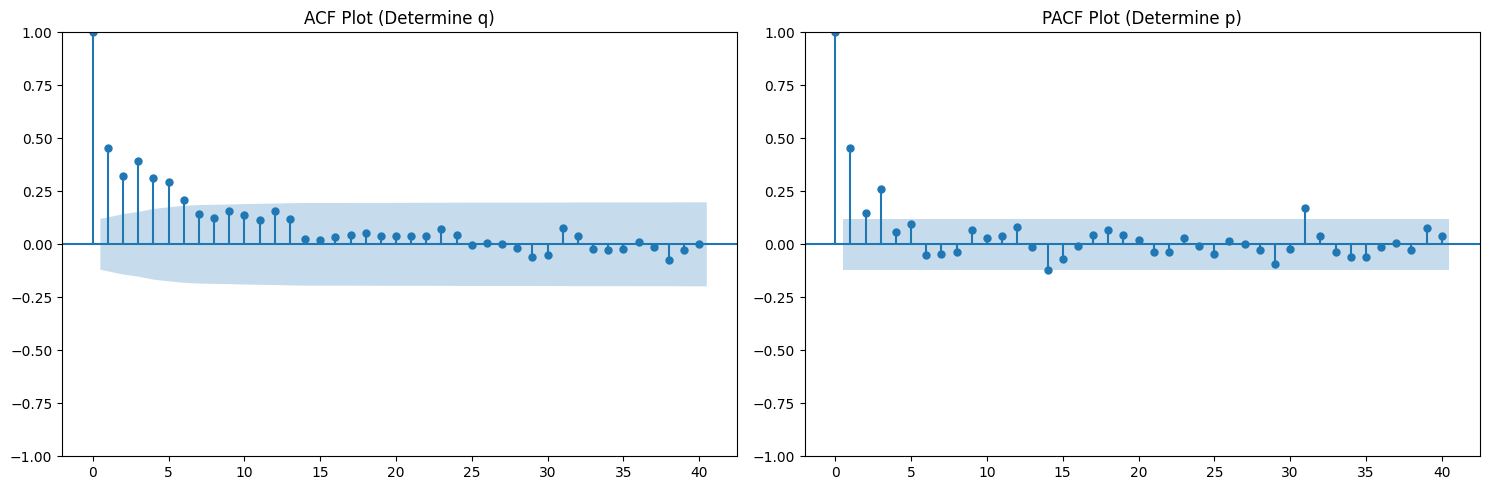

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the original sales series since d=0 (stationary already)
series = train_df['sales']

# Plot ACF and PACF to determine q and p
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF -> for q (MA part)
plot_acf(series, ax=axes[0], lags=40)
axes[0].set_title('ACF Plot (Determine q)')

# PACF -> for p (AR part)
plot_pacf(series, ax=axes[1], lags=40, method='ywm')  # 'ywm' is stable and preferred
axes[1].set_title('PACF Plot (Determine p)')

plt.tight_layout()
plt.show()


Series shows a strong autocoreelation at lag 1,but after that, the influence drops off.
observing the plot the value of AR(p) and MA(q) are likely to be 1 and 2. Also we have concluded value od d as 0 since the data is stationary.

### Training the model 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(train_df['sales'], order=(1, 0, 1))
model_fit = model.fit()

# Summary (optional)
print(model_fit.summary())


#### Forecast and Evaluate on Test Set

In [17]:
import numpy as np

Test RMSE: 3.0850538425743426


c:\Users\wwwsu\Desktop\All folders\Logistics_demand\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\wwwsu\Desktop\All folders\Logistics_demand\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


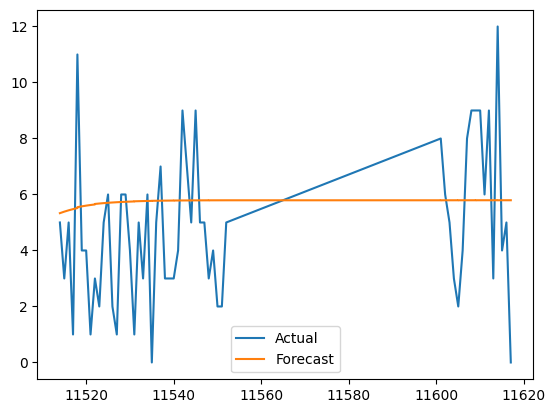

In [18]:
# Forecast length = length of test set
forecast_steps = len(test_df)

forecast = model_fit.forecast(steps=forecast_steps)

# Calculate RMSE
rmse = np.sqrt(np.mean((forecast - test_df['sales'].values) ** 2))
print(f"Test RMSE: {rmse}")

# plot actual vs forecast
import matplotlib.pyplot as plt

plt.plot(test_df['wm_yr_wk'], test_df['sales'], label='Actual')
plt.plot(test_df['wm_yr_wk'], forecast, label='Forecast')
plt.legend()
plt.show()


#### Keeping order (1,0,2)

In [24]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(train_df['sales'], order=(1, 0, 2))
model_fit = model.fit()

# Summary (optional)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  267
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -725.052
Date:                Sat, 03 May 2025   AIC                           1460.103
Time:                        18:50:00   BIC                           1478.040
Sample:                             0   HQIC                          1467.308
                                - 267                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8066      1.011      5.744      0.000       3.825       7.788
ar.L1          0.9040      0.056     16.227      0.000       0.795       1.013
ma.L1         -0.5714      0.073     -7.832      0.0

c:\Users\wwwsu\Desktop\All folders\Logistics_demand\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\wwwsu\Desktop\All folders\Logistics_demand\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\wwwsu\Desktop\All folders\Logistics_demand\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Test RMSE: 3.074598768732633


c:\Users\wwwsu\Desktop\All folders\Logistics_demand\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\wwwsu\Desktop\All folders\Logistics_demand\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


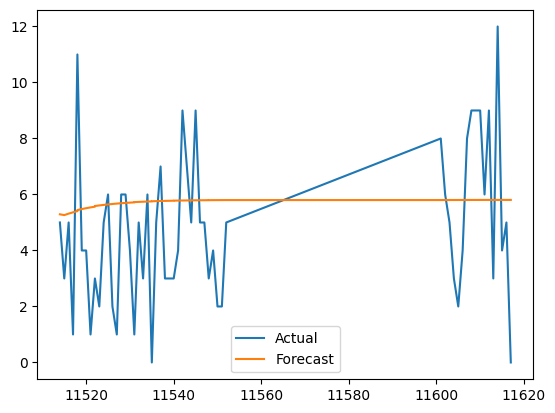

In [25]:
# Forecast length = length of test set
forecast_steps = len(test_df)

forecast = model_fit.forecast(steps=forecast_steps)

# Calculate RMSE
rmse = np.sqrt(np.mean((forecast - test_df['sales'].values) ** 2))
print(f"Test RMSE: {rmse}")

# plot actual vs forecast
import matplotlib.pyplot as plt

plt.plot(test_df['wm_yr_wk'], test_df['sales'], label='Actual')
plt.plot(test_df['wm_yr_wk'], forecast, label='Forecast')
plt.legend()
plt.show()

ARIMA model is not able to capture the real sales volatility. The RMSE tells the average error, and the plot shows the model’s limitation. More sophisticated models or additional features is needed for better results.